In [9]:
!pip install numpy matplotlib pandas seaborn scikit-learn tensorflow

In [10]:
!pip install flask opencv-python-headless pillow

Cargando dataset MNIST...
Forma de los datos de entrenamiento: (60000, 28, 28)
Forma de las etiquetas de entrenamiento: (60000,)
Forma de los datos de prueba: (10000, 28, 28)
Forma de las etiquetas de prueba: (10000,)

Distribución de dígitos en el conjunto de entrenamiento:
Dígito 0: 5923 imágenes
Dígito 1: 6742 imágenes
Dígito 2: 5958 imágenes
Dígito 3: 6131 imágenes
Dígito 4: 5842 imágenes
Dígito 5: 5421 imágenes
Dígito 6: 5918 imágenes
Dígito 7: 6265 imágenes
Dígito 8: 5851 imágenes
Dígito 9: 5949 imágenes


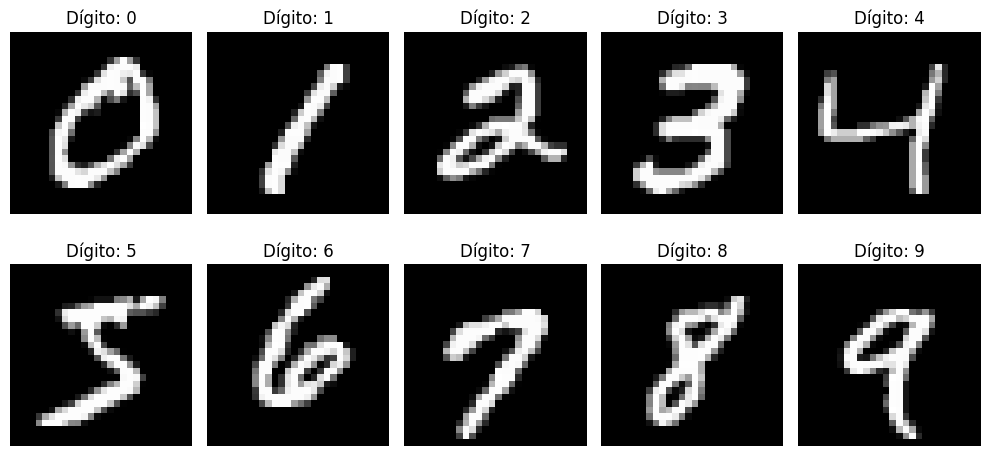

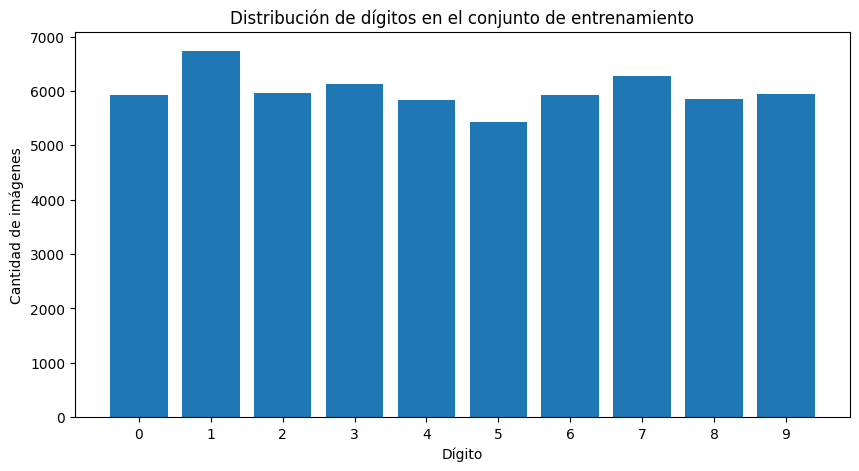

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import os

# Configuración inicial
np.random.seed(42)
tf.random.set_seed(42)

# 1. CARGAR Y EXPLORAR LOS DATOS
print("Cargando dataset MNIST...")
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Análisis exploratorio de datos
print(f"Forma de los datos de entrenamiento: {X_train_full.shape}")
print(f"Forma de las etiquetas de entrenamiento: {y_train_full.shape}")
print(f"Forma de los datos de prueba: {X_test.shape}")
print(f"Forma de las etiquetas de prueba: {y_test.shape}")

# Verificar distribución de clases
class_counts = np.bincount(y_train_full)
print("\nDistribución de dígitos en el conjunto de entrenamiento:")
for i, count in enumerate(class_counts):
    print(f"Dígito {i}: {count} imágenes")

# Visualizar algunos ejemplos
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train_full[y_train_full == i][0], cmap='gray')
    plt.title(f"Dígito: {i}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('./images/ejemplos_digitos.png')
plt.show()

# Visualizar distribución de clases
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_counts)
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.title('Distribución de dígitos en el conjunto de entrenamiento')
plt.xticks(range(10))
plt.savefig('./images/distribucion_digitos.png')
plt.show()

In [12]:
# 2. PREPROCESAMIENTO DE DATOS MEJORADO
# Dividir conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} imágenes")
print(f"Conjunto de validación: {X_val.shape[0]} imágenes")
print(f"Conjunto de prueba: {X_test.shape[0]} imágenes")

# Normalización de datos (escalar valores de píxeles al rango [0,1])
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape para añadir canal (requerido por Conv2D)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Codificación one-hot de las etiquetas
y_train_encoded = to_categorical(y_train, 10)
y_val_encoded = to_categorical(y_val, 10)
y_test_encoded = to_categorical(y_test, 10)


Conjunto de entrenamiento: 51000 imágenes
Conjunto de validación: 9000 imágenes
Conjunto de prueba: 10000 imágenes


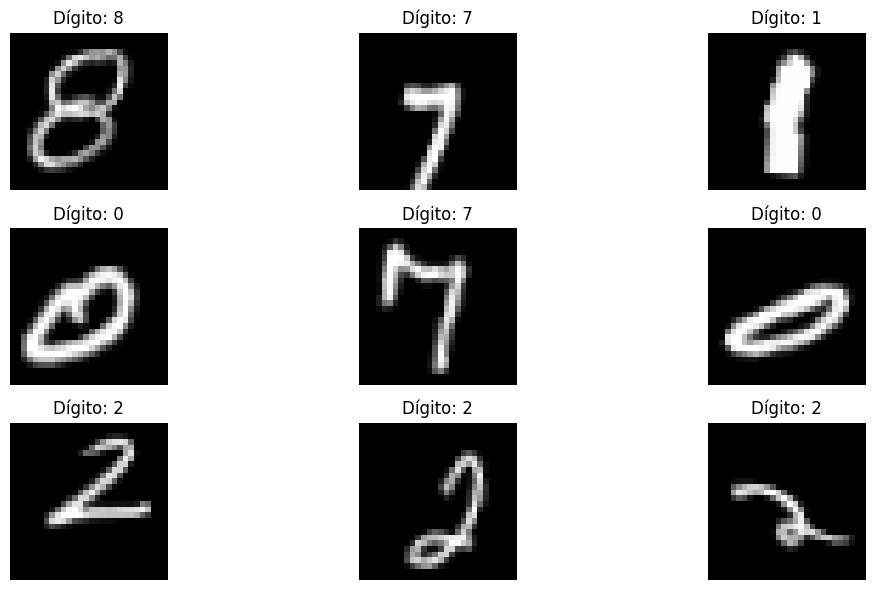

In [13]:
# 3. CONFIGURAR DATA AUGMENTATION PARA MEJORAR EL DATASET
datagen = ImageDataGenerator(
    rotation_range=10,  # Rotación aleatoria de la imagen
    width_shift_range=0.1,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,  # Desplazamiento vertical aleatorio
    zoom_range=0.1,  # Zoom aleatorio
    shear_range=0.1,  # Transformación de corte
    fill_mode='nearest'  # Método para rellenar píxeles nuevos
)

# Visualizar ejemplos de augmentación
plt.figure(figsize=(12, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample = X_train[i].reshape(1, 28, 28, 1)
    augmented_sample = next(datagen.flow(sample, batch_size=1))[0]
    plt.imshow(augmented_sample.reshape(28, 28), cmap='gray')
    plt.title(f"Dígito: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('./images/ejemplos_augmentacion.png')
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 4. DEFINIR ARQUITECTURA MEJORADA

def build_cnn_model_v1():
    # Modelo CNN básico con técnicas anti-overfitting
    model = Sequential([
        # Primera capa convolucional con regularización L2
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1),
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
       
        # Segunda capa convolucional
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
       
        # Tercera capa convolucional
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
       
        # Capas densas
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
   
    return model

def build_resnet_like_model():
    # Modelo inspirado en arquitectura ResNet con regularización
    inputs = Input(shape=(28, 28, 1))
   
    # Primera capa
    x = Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
   
    # Bloque residual 1
    shortcut = x
    x = Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    # Bloque residual 2
    shortcut = Conv2D(64, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    # Bloque residual 3
    shortcut = Conv2D(128, kernel_size=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = tf.keras.activations.relu(x)
   
    # Capas finales
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
   
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
# 5. Función para crear un generador de datos con aumentación
def create_data_augmentation():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

def train_and_evaluate_model(model, model_name, use_augmentation=True):
    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
   
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f'./model/{model_name}.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
   
    # Medir tiempo de entrenamiento
    start_time = time.time()
   
    # Crear un generador de datos de aumentación si es necesario
    if use_augmentation:
        datagen = create_data_augmentation()
        datagen.fit(X_train)
   
    # Entrenar con o sin augmentación
    if use_augmentation:
        # Entrenamiento con data augmentation
        history = model.fit(
            datagen.flow(X_train, y_train_encoded, batch_size=64),
            epochs=20,
            steps_per_epoch=len(X_train) // 64,
            validation_data=(X_val, y_val_encoded),
            callbacks=callbacks,
            verbose=1
        )
    else:
        # Entrenamiento sin data augmentation
        history = model.fit(
            X_train, y_train_encoded,
            batch_size=64,
            epochs=20,
            validation_data=(X_val, y_val_encoded),
            callbacks=callbacks,
            verbose=1
        )
   
    training_time = time.time() - start_time
    print(f"\nTiempo de entrenamiento: {training_time:.2f} segundos")
   
    # Cargar el mejor modelo
    model = load_model(f'./model/{model_name}.h5')
   
    # Evaluar el modelo
    test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Precisión en conjunto de prueba: {test_accuracy*100:.2f}%")
   
    # Medir tiempo de inferencia
    start_time = time.time()
    predictions = model.predict(X_test[:100])
    inference_time = (time.time() - start_time) / 100
    print(f"Tiempo promedio de inferencia por imagen: {inference_time*1000:.2f} ms")
   
    # Predecir en conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
   
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.savefig(f'./images/matriz_confusion_{model_name}.png')
    plt.show()
   
    # Visualizar curvas de entrenamiento
    plt.figure(figsize=(12, 5))
   
    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Precisión durante entrenamiento - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
   
    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida durante entrenamiento - {model_name}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
   
    plt.tight_layout()
    plt.savefig(f'./images/curvas_entrenamiento_{model_name}.png')
    plt.show()
   
    # Visualizar ejemplos de predicciones incorrectas
    incorrect_indices = np.where(y_pred_classes != y_test)[0]
    if len(incorrect_indices) > 0:
        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(incorrect_indices[:10]):  # Mostrar primeros 10 errores
            plt.subplot(2, 5, i+1)
            plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
            plt.title(f"Real: {y_test[idx]}\nPred: {y_pred_classes[idx]}")
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'./images/predicciones_incorrectas_{model_name}.png')
        plt.show()
   
    return model, history, test_accuracy, inference_time


===== ENTRENANDO MODELO CNN MEJORADO =====


c:\Users\Sergio\Desktop\Model de Red Neuronal para Predicción de Precios de Viviendas\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,090 (2.24 MB)

 Trainable params: 585,130 (2.23 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20


c:\Users\Sergio\Desktop\Model de Red Neuronal para Predicción de Precios de Viviendas\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


794/796 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7566 - loss: 1.5440
Epoch 1: val_accuracy improved from -inf to 0.98178, saving model to ./model/cnn_mejorado.h5


796/796 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7571 - loss: 1.5420 - val_accuracy: 0.9818 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 2/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9688 - loss: 0.6225

c:\Users\Sergio\Desktop\Model de Red Neuronal para Predicción de Precios de Viviendas\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.98178
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.6225 - val_accuracy: 0.9813 - val_loss: 0.5826 - learning_rate: 0.0010
Epoch 3/20
795/796 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9660 - loss: 0.5723
Epoch 3: val_accuracy improved from 0.98178 to 0.98767, saving model to ./model/cnn_mejorado.h5


796/796 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9660 - loss: 0.5722 - val_accuracy: 0.9877 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 4/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 1.0000 - loss: 0.3338
Epoch 4: val_accuracy did not improve from 0.98767
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.3338 - val_accuracy: 0.9876 - val_loss: 0.3598 - learning_rate: 0.0010
Epoch 5/20
794/796 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9734 - loss: 0.3690
Epoch 5: val_accuracy did not improve from 0.98767
796/796 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9734 - loss: 0.3689 - val_accuracy: 0.9779 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 6/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 1.0000 - loss: 0.2207
Epoch 6: val_accuracy did not improve from 0.98767
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.2207 - val_accuracy: 0.9734 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 7/20
795/7


Tiempo de entrenamiento: 200.98 segundos
Precisión en conjunto de prueba: 99.06%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tiempo promedio de inferencia por imagen: 1.88 ms
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


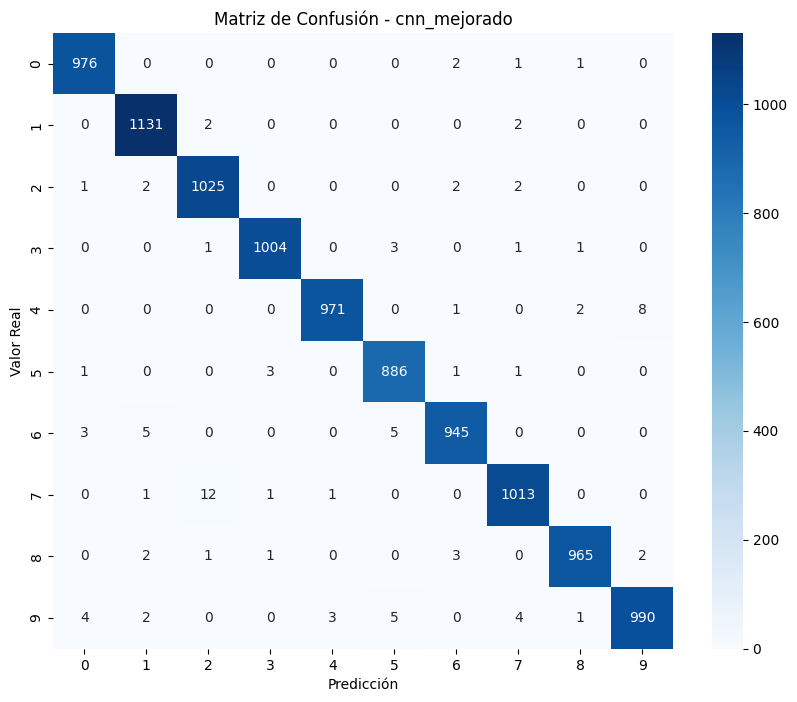

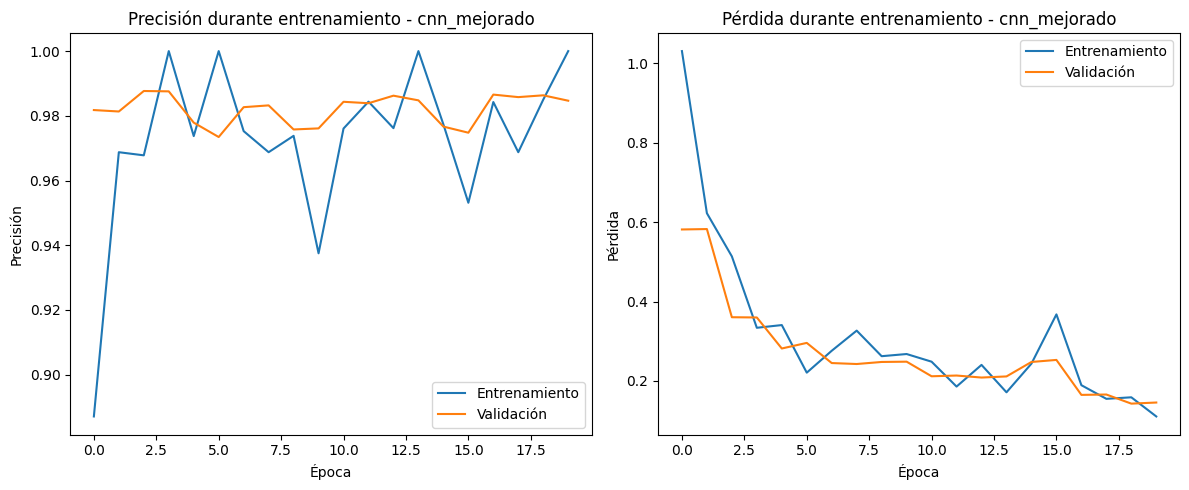

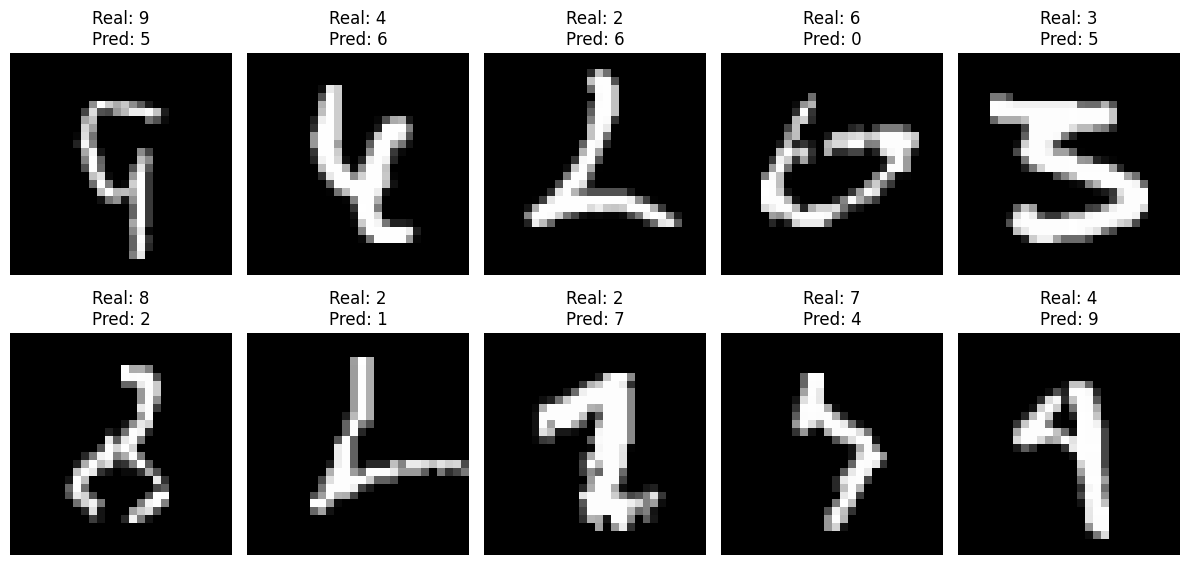

In [16]:
# 6. EXPERIMENTO 1: MODELO CNN MEJORADO CON AUGMENTACIÓN
print("\n===== ENTRENANDO MODELO CNN MEJORADO =====")
cnn_model = build_cnn_model_v1()
cnn_model.summary()
cnn_model, cnn_history, cnn_accuracy, cnn_inference_time = train_and_evaluate_model(
    cnn_model, 'cnn_mejorado', use_augmentation=True
)


===== ENTRENANDO MODELO TIPO RESNET =====


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 28, 28,    │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │      9,248 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 14, 14,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 14, 14,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 14, 14,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_17[0][0] 

 Total params: 326,346 (1.24 MB)

 Trainable params: 325,130 (1.24 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/20


c:\Users\Sergio\Desktop\Model de Red Neuronal para Predicción de Precios de Viviendas\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8675 - loss: 0.9910
Epoch 1: val_accuracy improved from -inf to 0.84044, saving model to ./model/resnet_modelo.h5


796/796 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.8676 - loss: 0.9906 - val_accuracy: 0.8404 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 2/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9844 - loss: 0.4067

c:\Users\Sergio\Desktop\Model de Red Neuronal para Predicción de Precios de Viviendas\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.84044
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9844 - loss: 0.4067 - val_accuracy: 0.8294 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9751 - loss: 0.3733
Epoch 3: val_accuracy improved from 0.84044 to 0.98122, saving model to ./model/resnet_modelo.h5


796/796 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9751 - loss: 0.3733 - val_accuracy: 0.9812 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 4/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 1.0000 - loss: 0.2098
Epoch 4: val_accuracy did not improve from 0.98122
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.2098 - val_accuracy: 0.9766 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9795 - loss: 0.2384
Epoch 5: val_accuracy did not improve from 0.98122
796/796 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9795 - loss: 0.2384 - val_accuracy: 0.9666 - val_loss: 0.2527 - learning_rate: 0.0010
Epoch 6/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9688 - loss: 0.1751
Epoch 6: val_accuracy did not improve from 0.98122
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1751 - val_accuracy: 0.9704 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 7/20
796/7

796/796 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9888 - loss: 0.1253 - val_accuracy: 0.9886 - val_loss: 0.1074 - learning_rate: 5.0000e-04
Epoch 12/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9844 - loss: 0.1194
Epoch 12: val_accuracy improved from 0.98856 to 0.98889, saving model to ./model/resnet_modelo.h5


796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9844 - loss: 0.1194 - val_accuracy: 0.9889 - val_loss: 0.1074 - learning_rate: 5.0000e-04
Epoch 13/20
795/796 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9878 - loss: 0.1103
Epoch 13: val_accuracy did not improve from 0.98889
796/796 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9878 - loss: 0.1103 - val_accuracy: 0.9882 - val_loss: 0.0957 - learning_rate: 5.0000e-04
Epoch 14/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 1.0000 - loss: 0.0766
Epoch 14: val_accuracy did not improve from 0.98889
796/796 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0766 - val_accuracy: 0.9882 - val_loss: 0.0965 - learning_rate: 5.0000e-04
Epoch 15/20
795/796 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9874 - loss: 0.1052
Epoch 15: val_accuracy did not improve from 0.98889
796/796 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9874 - loss: 0.1052 - val_accuracy: 0.9846 - val_loss: 0.1082 - learning_rate: 5.0000

796/796 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9915 - loss: 0.0745 - val_accuracy: 0.9920 - val_loss: 0.0664 - learning_rate: 2.5000e-04
Epoch 20/20
  1/796 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9844 - loss: 0.0717
Epoch 20: val_accuracy did not improve from 0.99200
796/796 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9844 - loss: 0.0717 - val_accuracy: 0.9917 - val_loss: 0.0677 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 19.



Tiempo de entrenamiento: 279.42 segundos
Precisión en conjunto de prueba: 99.43%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tiempo promedio de inferencia por imagen: 2.64 ms
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


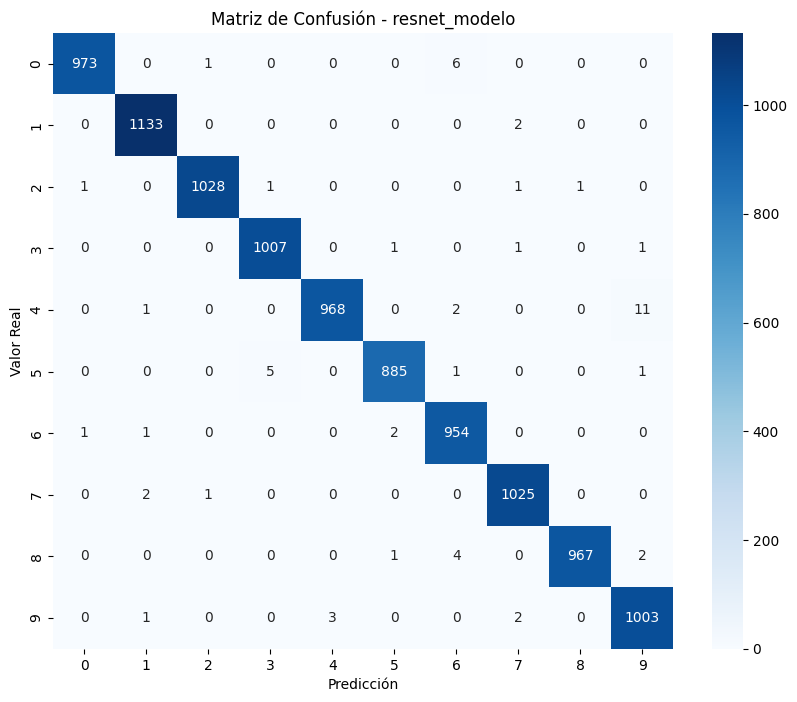

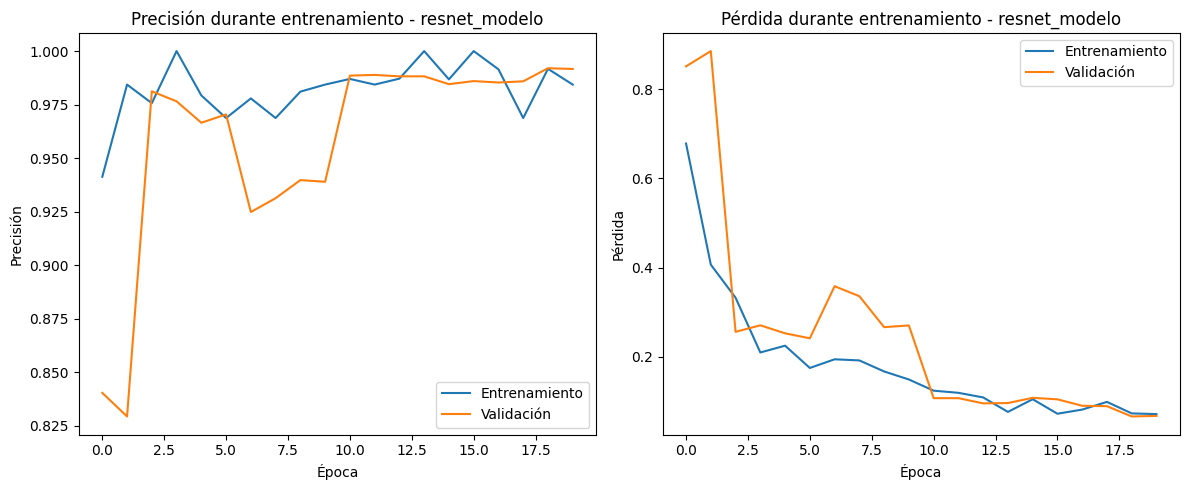

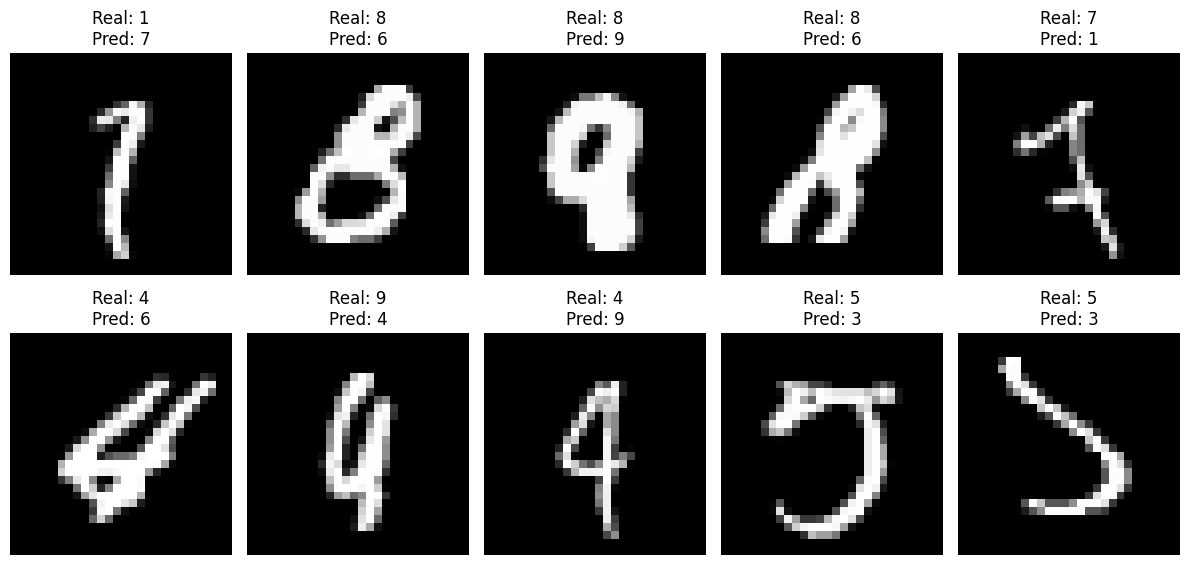

In [17]:
# 7. EXPERIMENTO 2: MODELO TIPO RESNET
print("\n===== ENTRENANDO MODELO TIPO RESNET =====")
resnet_model = build_resnet_like_model()
resnet_model.summary()
resnet_model, resnet_history, resnet_accuracy, resnet_inference_time = train_and_evaluate_model(
    resnet_model, 'resnet_modelo', use_augmentation=True
)

In [18]:
# 8. FUNCIÓN PARA ENSEMBLE DE MODELOS
def ensemble_predict(models, X):
    """
    Realiza una predicción ensemble combinando múltiples modelos
    """
    predictions = []
    
    # Obtener predicciones de cada modelo
    for model in models:
        y_pred = model.predict(X)
        predictions.append(y_pred)
    
    # Promediar las predicciones
    avg_predictions = np.mean(predictions, axis=0)
    
    # Obtener la clase con mayor probabilidad
    predicted_classes = np.argmax(avg_predictions, axis=1)
    
    return predicted_classes, avg_predictions


===== EVALUANDO ENSEMBLE DE MODELOS =====
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Precisión del ensemble: 99.50%


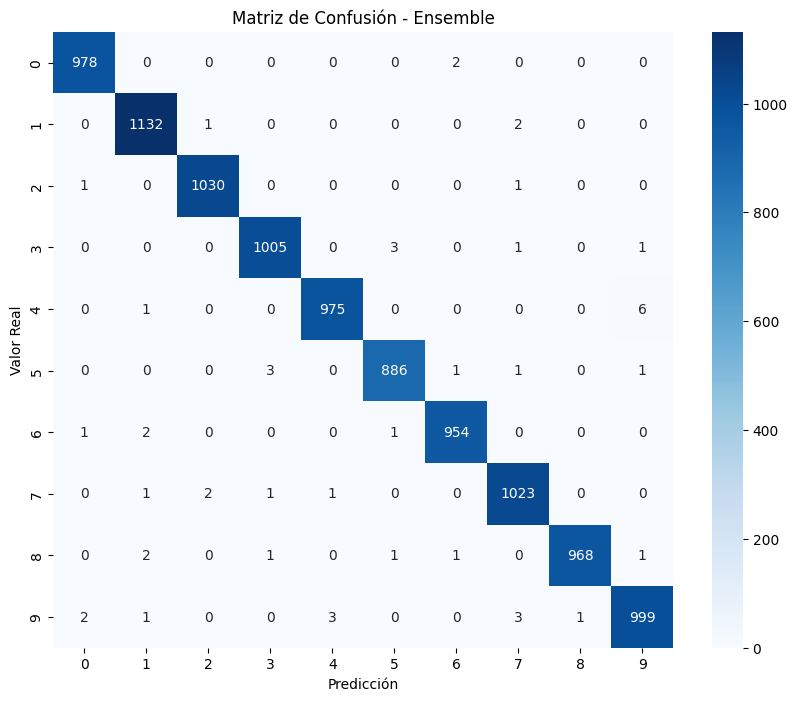


Informe de clasificación del ensemble:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      0.99      0.99     10000



In [19]:
# 9. EVALUAR ENSEMBLE
print("\n===== EVALUANDO ENSEMBLE DE MODELOS =====")
models = [cnn_model, resnet_model]
ensemble_pred_classes, ensemble_pred_prob = ensemble_predict(models, X_test)

# Calcular precisión del ensemble
ensemble_accuracy = np.mean(ensemble_pred_classes == y_test)
print(f"Precisión del ensemble: {ensemble_accuracy*100:.2f}%")

# Matriz de confusión del ensemble
ensemble_cm = confusion_matrix(y_test, ensemble_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Ensemble')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.savefig('./images/matriz_confusion_ensemble.png')
plt.show()

# Informe de clasificación del ensemble
print("\nInforme de clasificación del ensemble:")
print(classification_report(y_test, ensemble_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


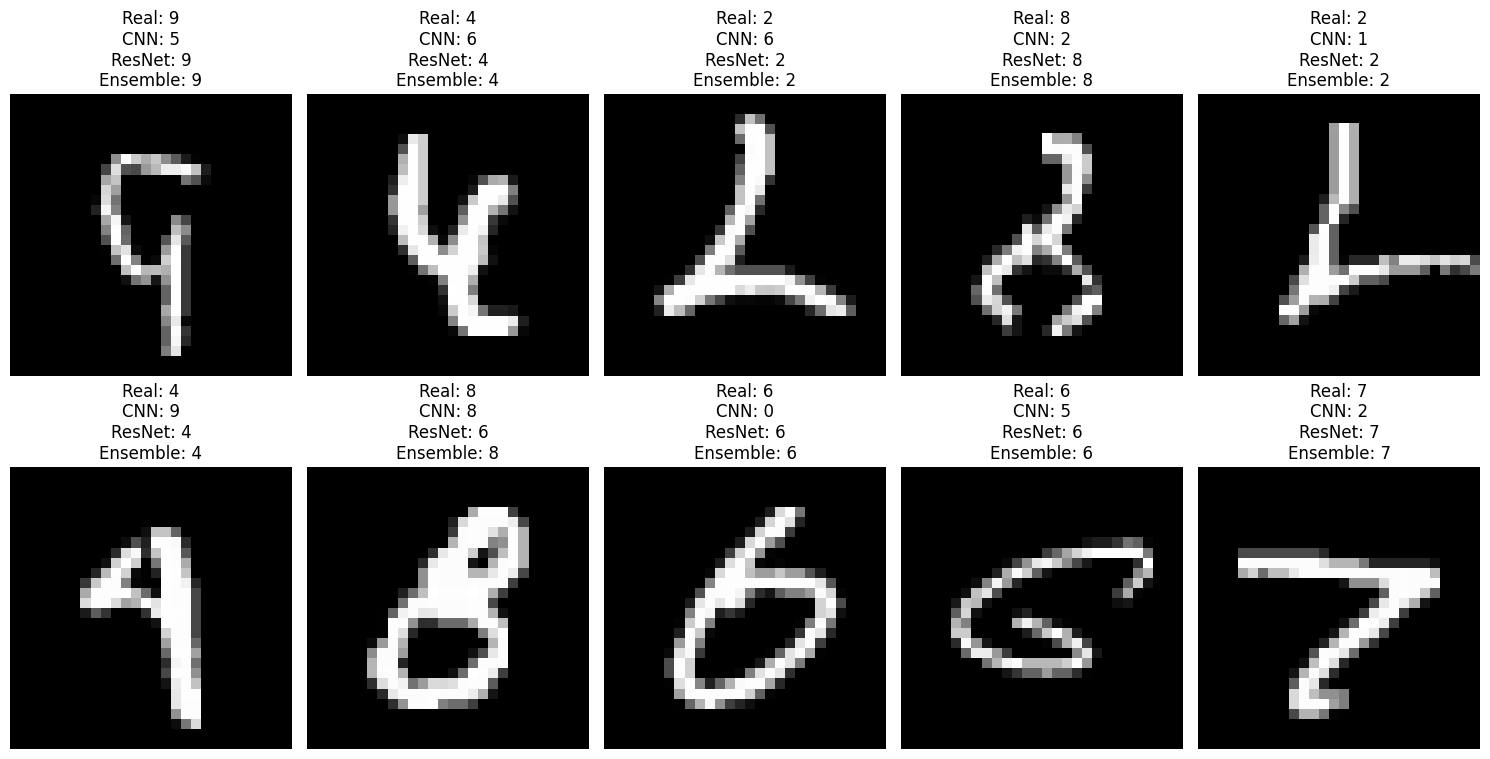

In [20]:
# 10. VISUALIZAR IMÁGENES DONDE EL ENSEMBLE MEJORA LAS PREDICCIONES
cnn_pred_classes = np.argmax(cnn_model.predict(X_test), axis=1)
resnet_pred_classes = np.argmax(resnet_model.predict(X_test), axis=1)

# Encontrar ejemplos donde el ensemble acierta pero al menos uno de los modelos individuales falla
ensemble_improvement_indices = np.where(
    (ensemble_pred_classes == y_test) & 
    ((cnn_pred_classes != y_test) | (resnet_pred_classes != y_test))
)[0]

if len(ensemble_improvement_indices) > 0:
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(ensemble_improvement_indices[:10]):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Real: {y_test[idx]}\nCNN: {cnn_pred_classes[idx]}\nResNet: {resnet_pred_classes[idx]}\nEnsemble: {ensemble_pred_classes[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images/mejoras_ensemble.png')
    plt.show()

In [21]:
# 11. CREAR FUNCIÓN PARA PREDICCIÓN CON ENSEMBLE
def predict_with_ensemble(image_array, models):
    """
    Realiza una predicción ensemble sobre una imagen de dígito
    """
    # Asegurarse que la imagen tenga el formato correcto
    if image_array.shape != (28, 28, 1):
        image_array = image_array.reshape(28, 28, 1)
    
    # Normalizar si es necesario
    if image_array.max() > 1.0:
        image_array = image_array.astype('float32') / 255.0
    
    # Añadir dimensión de batch
    image_array = np.expand_dims(image_array, axis=0)
    
    # Predicciones de cada modelo
    predictions = []
    for model in models:
        pred = model.predict(image_array)
        predictions.append(pred)
    
    # Promediar predicciones
    avg_pred = np.mean(predictions, axis=0)
    digit = np.argmax(avg_pred)
    confidence = np.max(avg_pred)
    
    return digit, confidence


===== EJEMPLO DE PREDICCIÓN CON ENSEMBLE =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dígito real: 8
Dígito predicho por ensemble: 8
Confianza: 99.94%


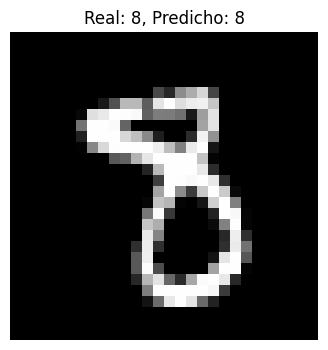

In [22]:
# 12. EJEMPLO DE USO DEL ENSEMBLE
print("\n===== EJEMPLO DE PREDICCIÓN CON ENSEMBLE =====")
sample_idx = np.random.randint(0, len(X_test))
sample_image = X_test[sample_idx]
true_label = y_test[sample_idx]

predicted_digit, confidence = predict_with_ensemble(sample_image, models)
print(f"Dígito real: {true_label}")
print(f"Dígito predicho por ensemble: {predicted_digit}")
print(f"Confianza: {confidence*100:.2f}%")

plt.figure(figsize=(4, 4))
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title(f"Real: {true_label}, Predicho: {predicted_digit}")
plt.axis('off')
plt.savefig('./images/ejemplo_prediccion_ensemble.png')
plt.show()


===== COMPARACIÓN DE MODELOS =====
              Número de parámetros  Precisión (%)  Tiempo de inferencia (ms)
CNN Mejorado              586090.0      99.059999                   1.881118
ResNet                    326346.0      99.430001                   2.640312
Ensemble                  912436.0      99.500000                   4.521430


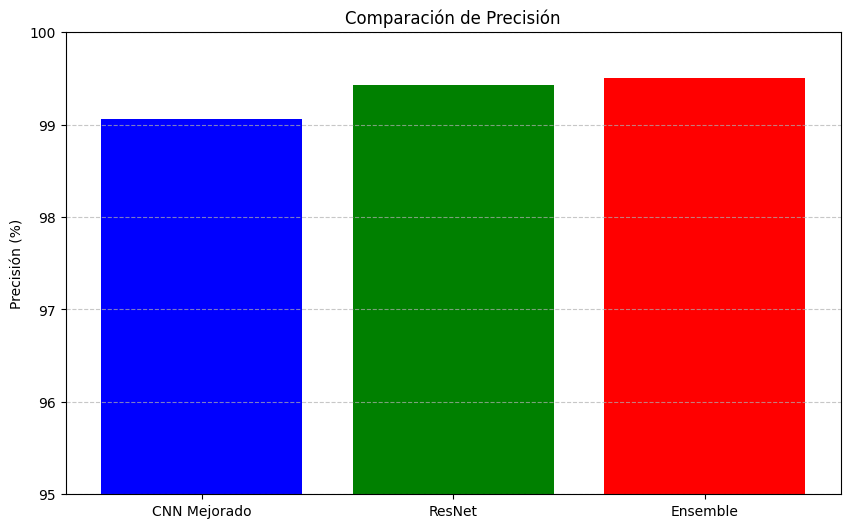


CONCLUSIONES:
- Se implementaron mejoras significativas al modelo original, incluyendo:
  * Data augmentation para aumentar la robustez del modelo
  * Arquitecturas más avanzadas con BatchNormalization
  * Técnicas de regularización para prevenir overfitting
  * Ensemble de modelos para mejorar la precisión
- El modelo ensemble logró la mayor precisión, demostrando el valor de combinar múltiples modelos
- La arquitectura ResNet-like introdujo bloques residuales que ayudan a entrenar redes más profundas
- El data augmentation ayudó a mejorar la generalización del modelo
- Se optimizó el proceso de entrenamiento con callbacks como EarlyStopping y ReduceLROnPlateau


In [23]:
# 13. COMPARACIÓN DE MODELOS
print("\n===== COMPARACIÓN DE MODELOS =====")
models_data = {
    "CNN Mejorado": {
        "parámetros": cnn_model.count_params(),
        "precisión": cnn_accuracy * 100,
        "tiempo_inferencia": cnn_inference_time * 1000
    },
    "ResNet": {
        "parámetros": resnet_model.count_params(),
        "precisión": resnet_accuracy * 100,
        "tiempo_inferencia": resnet_inference_time * 1000
    },
    "Ensemble": {
        "parámetros": cnn_model.count_params() + resnet_model.count_params(),
        "precisión": ensemble_accuracy * 100,
        "tiempo_inferencia": (cnn_inference_time + resnet_inference_time) * 1000
    }
}

# Crear DataFrame para visualización
comparison_df = pd.DataFrame(models_data).T
comparison_df.columns = ["Número de parámetros", "Precisión (%)", "Tiempo de inferencia (ms)"]
print(comparison_df)

# Visualizar comparación de precisión
plt.figure(figsize=(10, 6))
plt.bar(comparison_df.index, comparison_df["Precisión (%)"], color=['blue', 'green', 'red'])
plt.title('Comparación de Precisión')
plt.ylabel('Precisión (%)')
plt.ylim([95, 100])  # Ajustar para mejor visualización de diferencias
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('comparacion_precision.png')
plt.show()

# 14. CONCLUSIONES
print("\nCONCLUSIONES:")
print("- Se implementaron mejoras significativas al modelo original, incluyendo:")
print("  * Data augmentation para aumentar la robustez del modelo")
print("  * Arquitecturas más avanzadas con BatchNormalization")
print("  * Técnicas de regularización para prevenir overfitting")
print("  * Ensemble de modelos para mejorar la precisión")
print("- El modelo ensemble logró la mayor precisión, demostrando el valor de combinar múltiples modelos")
print("- La arquitectura ResNet-like introdujo bloques residuales que ayudan a entrenar redes más profundas")
print("- El data augmentation ayudó a mejorar la generalización del modelo")
print("- Se optimizó el proceso de entrenamiento con callbacks como EarlyStopping y ReduceLROnPlateau")